In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import tensorflow as tf
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [2]:
sample_size = 465
width = 150
height = 150

In [3]:
files = ['A', 'B','C']
file_path = "D:/TITO/Documents/BANGKIT/capstone/protoype2/data5/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)

In [4]:
print(len(data['A']))
print(len(data['B']))
print(len(data['C']))

165
150
150


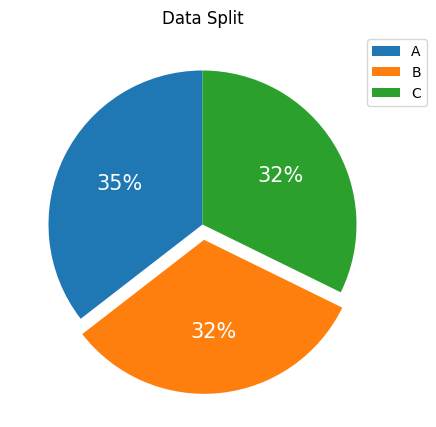

In [5]:
sizes = [len(data['A']), len(data['B']), len(data['C'])]
explode = (0, 0.1, 0) 

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [6]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class C
Calculate Time 28.50352


In [7]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(465, 150, 150, 3)

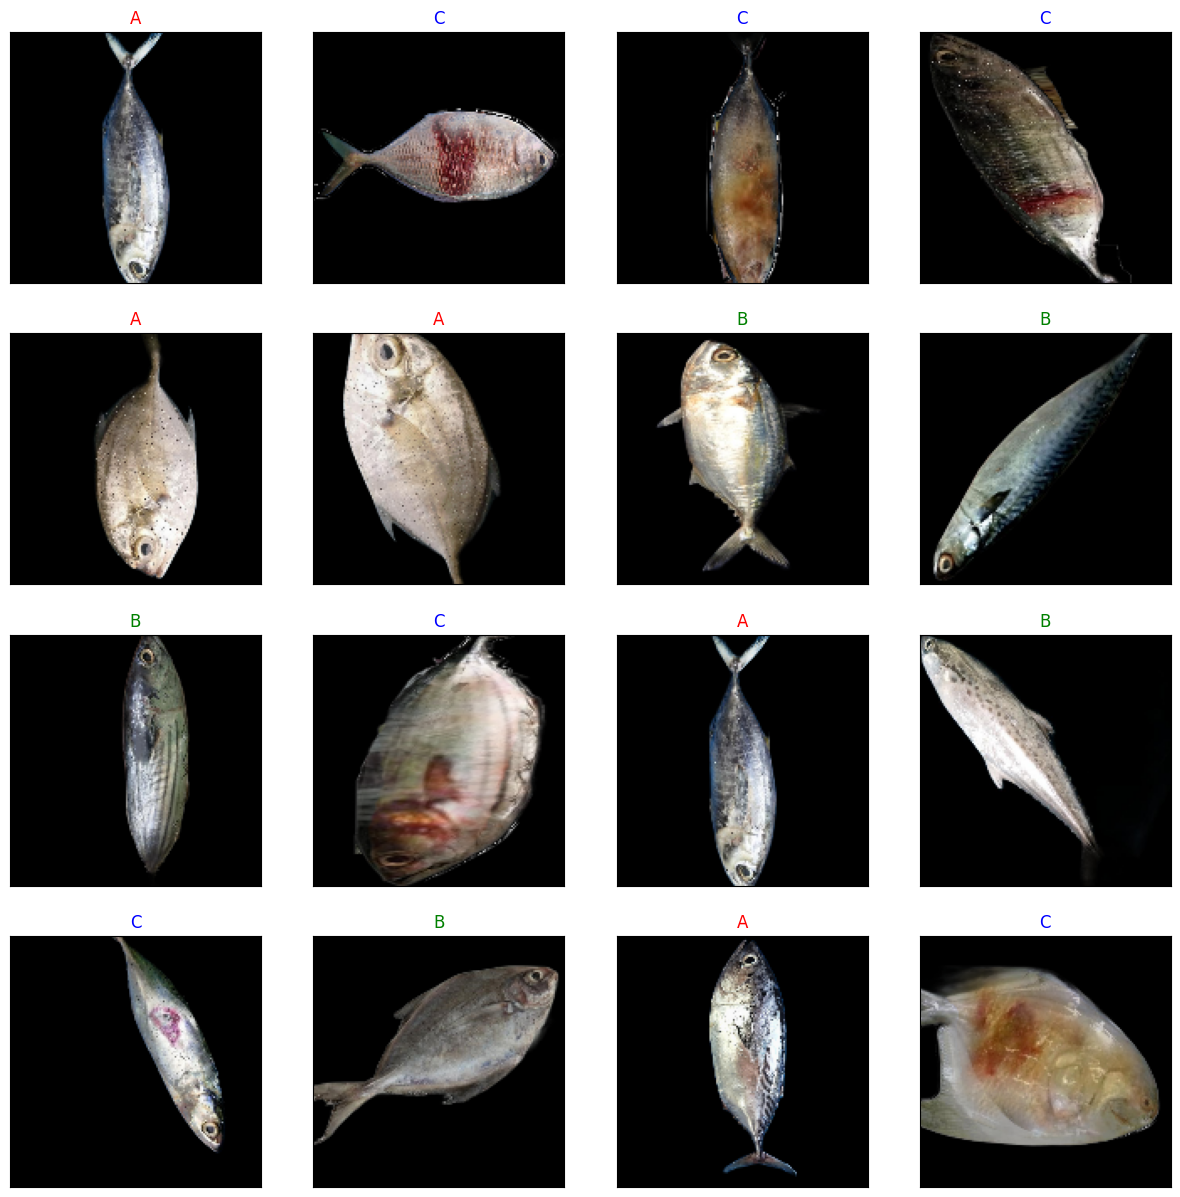

In [8]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [10]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [13]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-tr

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=50,
                                                restore_best_weights=True)


In [16]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50


UnimplementedError: Graph execution error:

Detected at node 'sequential/mobilenetv2_1.00_224/Conv1/Conv2D' defined at (most recent call last):
    File "d:\Anaconda\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\Anaconda\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\Anaconda\envs\tf\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "d:\Anaconda\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "d:\Anaconda\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "d:\Anaconda\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "d:\Anaconda\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "d:\Anaconda\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Anaconda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS TUF GAMING\AppData\Local\Temp\ipykernel_4488\299555591.py", line 17, in <module>
      history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "d:\Anaconda\envs\tf\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/mobilenetv2_1.00_224/Conv1/Conv2D'
DNN library is not found.
	 [[{{node sequential/mobilenetv2_1.00_224/Conv1/Conv2D}}]] [Op:__inference_train_function_8487]

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  154


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 577,155
Non-

In [ ]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
11/11 [==============================] - 4s 199ms/step - loss: 0.4606 - accuracy: 0.8369 - categorical_accuracy: 0.3508 - val_loss: 0.3792 - val_accuracy: 0.8786 - val_categorical_accuracy: 0.3643 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 1s 93ms/step - loss: 0.2934 - accuracy: 0.8954 - categorical_accuracy: 0.3385 - val_loss: 0.6949 - val_accuracy: 0.7429 - val_categorical_accuracy: 0.3071 - lr: 9.0484e-04
Epoch 3/50
11/11 [==============================] - 1s 94ms/step - loss: 0.2248 - accuracy: 0.9385 - categorical_accuracy: 0.3385 - val_loss: 0.4837 - val_accuracy: 0.8143 - val_categorical_accuracy: 0.3500 - lr: 8.1873e-04
Epoch 4/50
11/11 [==============================] - 1s 93ms/step - loss: 0.1610 - accuracy: 0.9292 - categorical_accuracy: 0.3600 - val_loss: 0.4326 - val_accuracy: 0.8500 - val_categorical_accuracy: 0.3429 - lr: 7.4082e-04
Epoch 5/50
11/11 [==============================] - 1s 93ms/step - loss: 0.1449 - accuracy: 0.9538 - catego

5/5 - 0s - loss: 0.3808 - accuracy: 0.8929 - categorical_accuracy: 0.3500 - 342ms/epoch - 68ms/step


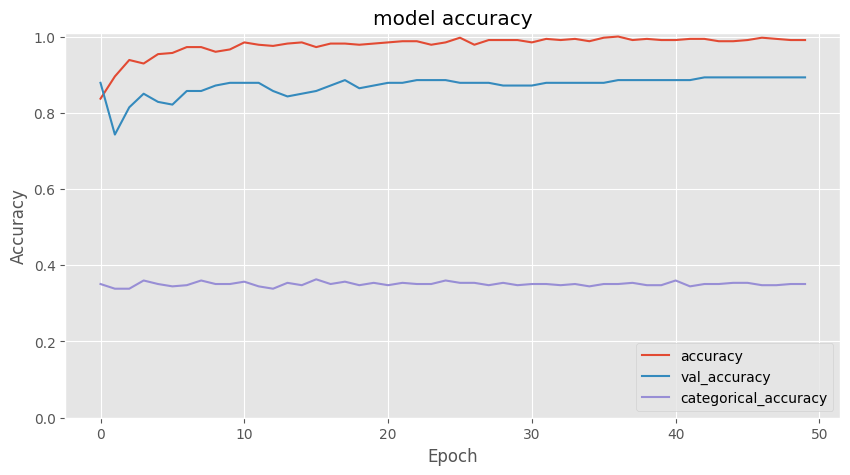

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

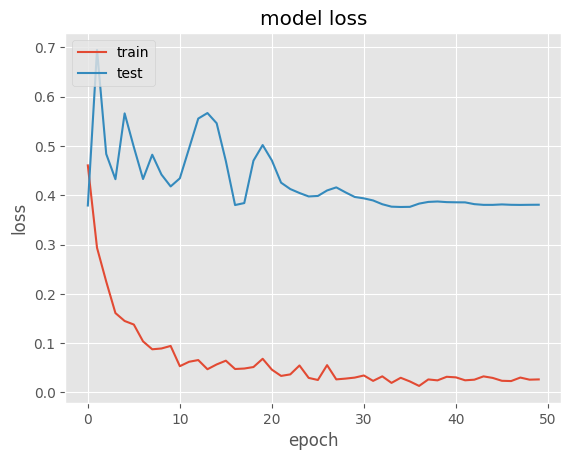

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result=model.evaluate(train_images, train_labels)

11/11 [==============================] - 1s 60ms/step - loss: 0.0100 - accuracy: 0.9938 - categorical_accuracy: 0.3569


In [ ]:
result=model.evaluate(test_images, test_labels)

5/5 [==============================] - 0s 54ms/step - loss: 0.3808 - accuracy: 0.8929 - categorical_accuracy: 0.3500


In [ ]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.3807692527770996
accuracy : 0.8928571343421936
categorical_accuracy : 0.3499999940395355


In [ ]:
# model.summary()

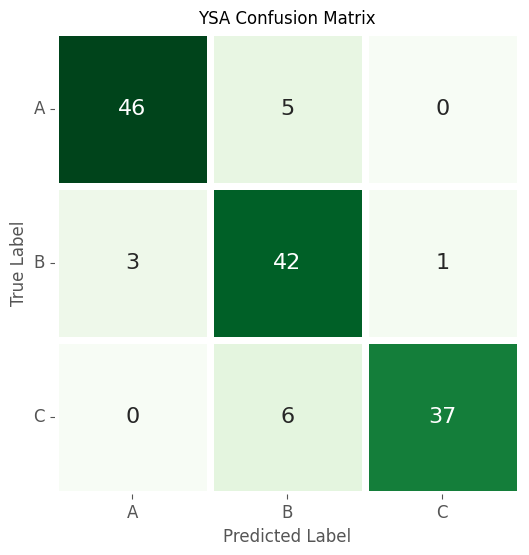

In [ ]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [ ]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.901638


In [ ]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.891823


In [ ]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.894022


In [ ]:
def Prediction(image):

    global width, height, files, labels

    img = cv2.resize(image,(width,height))

    test = img / 255.0

    pred = model.predict(np.array([image])).argmax()

    return labels.inverse_transform([pred])[0]

In [ ]:
def Prediction2(test_image):

    global width, height, files, labels

    img = image.img_to_array(test_image)
    img = np.expand_dims(img, axis=0)
    img = img/255.0
    
    class_list = ['A', 'B', 'C'] 
    
    pred = model.predict(img)
    predicted_class = class_list[np.argmax(pred[0])]
    return predicted_class

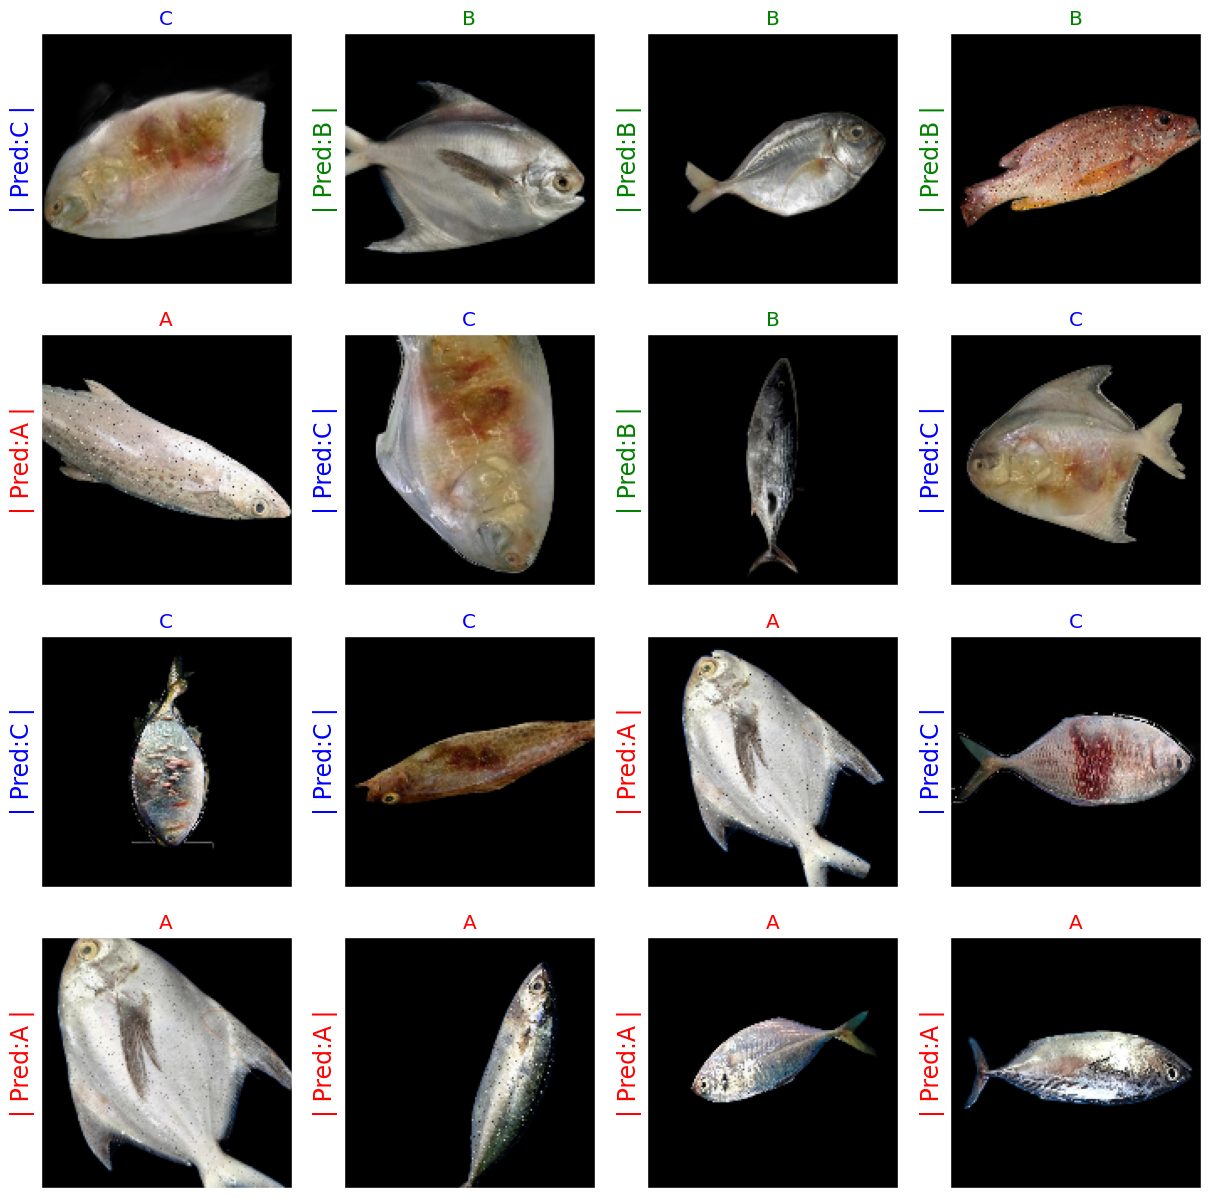

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction2(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

1.jpg
Prediction range:
Minimum value: 3.1022195e-05
Maximum value: 0.99931777
Grade: A
Good
10.jpg
Prediction range:
Minimum value: 5.152047e-06
Maximum value: 0.6802627
Grade: C
Bad
100.jpg
Prediction range:
Minimum value: 0.0014952293
Maximum value: 0.896675
Grade: A
Good
101.jpg
Prediction range:
Minimum value: 0.1538873
Maximum value: 0.5774214
Grade: A
Good
102.jpg
Prediction range:
Minimum value: 0.00535027
Maximum value: 0.92335296
Grade: A
Good
103.jpg
Prediction range:
Minimum value: 0.0014433224
Maximum value: 0.9520861
Grade: A
Good
104.jpg
Prediction range:
Minimum value: 0.0029506884
Maximum value: 0.89900255
Grade: A
Good
106.jpg
Prediction range:
Minimum value: 0.13628468
Maximum value: 0.59695566
Grade: A
Good
107.jpg
Prediction range:
Minimum value: 0.06589371
Maximum value: 0.80447155
Grade: A
Good
108.jpg
Prediction range:
Minimum value: 0.09573428
Maximum value: 0.71223104
Grade: A
Good
109.jpg
Prediction range:
Minimum value: 0.021174071
Maximum value: 0.8895755
G

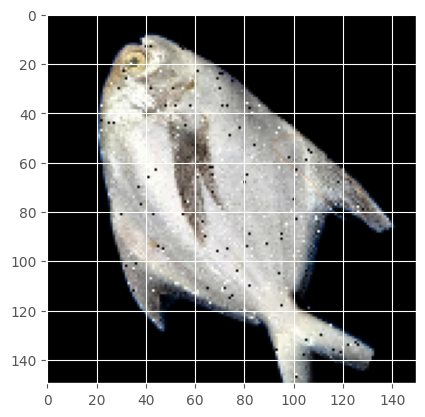

In [ ]:
# user_path = r"C:\laragon\www\Project\Bloomy\img\output"
user_path = r"D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\data2\\A"

image_files = os.listdir(user_path)
for idx in range(0, 149):
    index = idx
    image_file = os.path.join(user_path, image_files[index])

    print(image_files[index])
    img = image.load_img(image_file, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 

    classes = model.predict(x, batch_size=1)
    nilai_min = np.min(classes)
    nilai_max = np.max(classes)

    print("Prediction range:")
    print("Minimum value:", nilai_min)
    print("Maximum value:", nilai_max)

    class_list = ['A', 'B', 'C'] 

    predicted_class = class_list[np.argmax(classes[0])]
    print('Grade:', predicted_class)

    if predicted_class == 'A':
        print('Good')
    

    elif predicted_class == 'B':
        print('Medium')


    elif predicted_class == 'C':
        print('Bad')

In [ ]:
# file_location = 'D:\\Users\\Andra\Documents\\Bloomy\\prototype\\fish_grading.h5'
# file_location = 'C:\laragon\www\Project\Bloomy\model\\fishgrading.h5'
# file_location = 'D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\model_grading_mobilenet.h5'

# model.save(file_location)